In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from analysis.datasets import *
from analysis.first_analysis import *
from analysis.explorative_analysis import *
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import weibull_min
from scipy.special import gamma
import scipy.stats as stats

C:\Users\Manuel\Documents\Masterarbeit\src\analysis\first_analysis.py:76: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, pdf, 'r-', label=f'Normal Fit\n$\mu={mean:.2f}$, $\sigma={std:.2f}$')
C:\Users\Manuel\Documents\Masterarbeit\src\analysis\first_analysis.py:76: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, pdf, 'r-', label=f'Normal Fit\n$\mu={mean:.2f}$, $\sigma={std:.2f}$')


### Loading 50Hertz Data

In [2]:
aggregated_power = load_entsoe()

### explorative_analysis(df)

In [3]:
explorative_analysis(aggregated_power)

Summary statistics for time frame: 2016-01-01 - 2024-12-31
First 5 rows of the dataframe:


,offshore,onshore
time,,
2016-01-01 00:00:00,21.0,1428.0
2016-01-01 00:15:00,27.0,1379.0
2016-01-01 00:30:00,24.0,1399.0
2016-01-01 00:45:00,20.0,1448.0
2016-01-01 01:00:00,16.0,1517.0



Last 5 rows of the dataframe:


,offshore,onshore
time,,
2024-12-31 22:45:00,NaN,NaN
2024-12-31 23:00:00,NaN,NaN
2024-12-31 23:15:00,NaN,NaN
2024-12-31 23:30:00,NaN,NaN
2024-12-31 23:45:00,NaN,NaN



Summary statistics of the dataframe for time frame: 2016-01-01 - 2024-12-31


,offshore,onshore
count,307842.000000,307842.000000
mean,369.573703,3727.880780
std,346.738522,3359.502551
min,0.000000,0.000000
25%,75.000000,1109.250000
50%,272.000000,2634.000000
75%,600.000000,5413.750000
max,1480.000000,16676.000000


Expected number of entries: 315648 (2016-01-01 00:00:00 - 2024-12-31 23:45:00) 
Actual number of entries: 315648

Shape of dataframe (rows, columns) for time frame: 2016-01-01 - 2024-12-31


(315648, 2)


Checking for duplicates in the index for time frame: 2016-01-01 - 2024-12-31
Index column has no duplicates.


KeyError: 'Power (kW)'

### First Analyses

I want to analyze for each 15 minute interval which distribution fits the data best. To this end, I turn the data frame into new one with index = day and 96 columns (24 * 4 as there are 4 15 minute intervals per hour) (both onshore and offshore i.e. 192 in total)

In [3]:
reshaped = add_previous_day_and_calculate_differences(aggregated_power)
reshaped

,P_onshore_00_00,P_onshore_00_15,P_onshore_00_30,P_onshore_00_45,P_onshore_01_00,P_onshore_01_15,P_onshore_01_30,P_onshore_01_45,P_onshore_02_00,P_onshore_02_15,...,ΔP_onshore_21_30,ΔP_onshore_21_45,ΔP_onshore_22_00,ΔP_onshore_22_15,ΔP_onshore_22_30,ΔP_onshore_22_45,ΔP_onshore_23_00,ΔP_onshore_23_15,ΔP_onshore_23_30,ΔP_onshore_23_45
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1428.0,1379.0,1399.0,1448.0,1517.0,1511.0,1539.0,1575.0,1628.0,1685.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,595.0,650.0,696.0,735.0,738.0,774.0,853.0,939.0,985.0,1030.0,...,6497.0,6459.0,6426.0,6375.0,6365.0,6339.0,6233.0,6179.0,6163.0,6193.0
2016-01-03,6600.0,6634.0,6645.0,6644.0,6646.0,6764.0,6858.0,6846.0,6846.0,6847.0,...,-1436.0,-1474.0,-1532.0,-1464.0,-1525.0,-1516.0,-1445.0,-1443.0,-1438.0,-1501.0
2016-01-04,5069.0,4983.0,4867.0,4754.0,4739.0,4644.0,4676.0,4629.0,4584.0,4394.0,...,-3093.0,-3140.0,-3076.0,-3123.0,-3100.0,-3072.0,-3061.0,-3103.0,-3134.0,-3170.0
2016-01-05,2081.0,2115.0,2108.0,2082.0,2083.0,2045.0,2050.0,2116.0,2089.0,2010.0,...,-809.0,-754.0,-786.0,-759.0,-745.0,-786.0,-841.0,-795.0,-882.0,-929.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


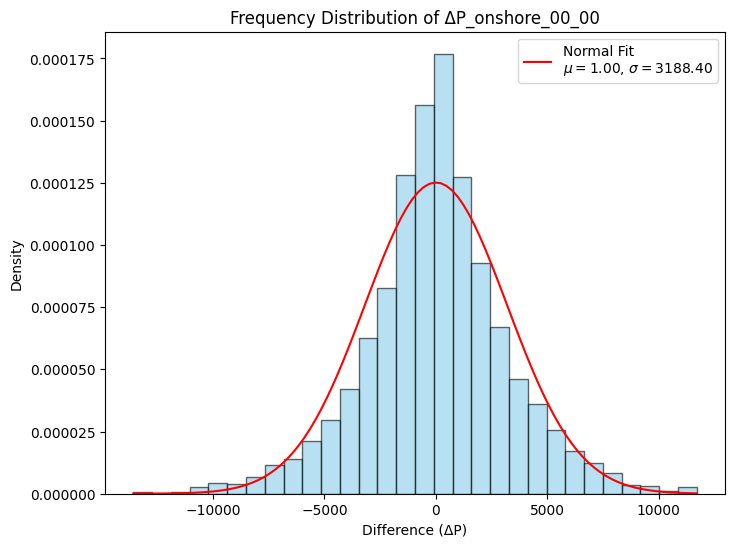

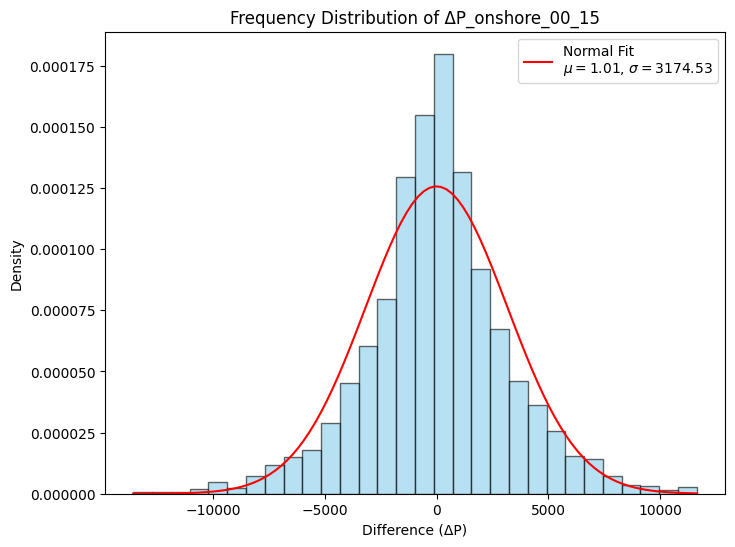

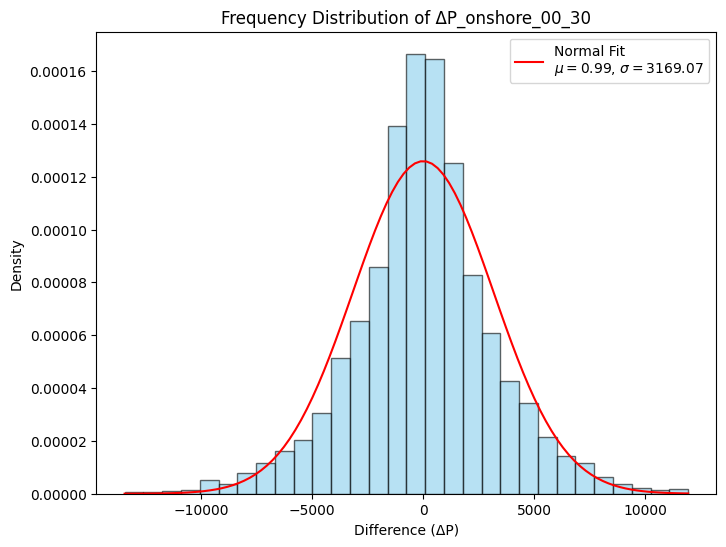

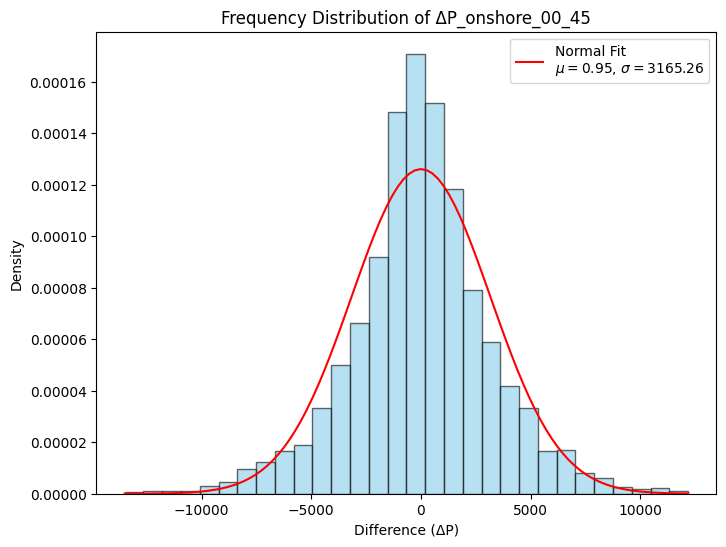

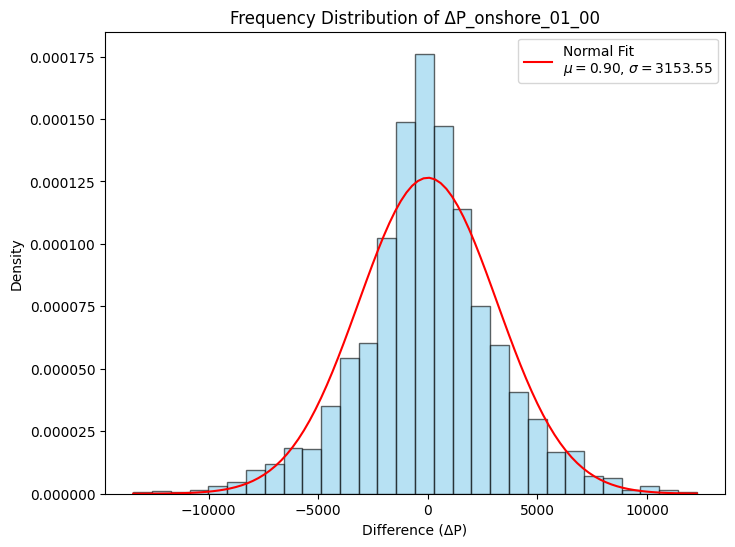

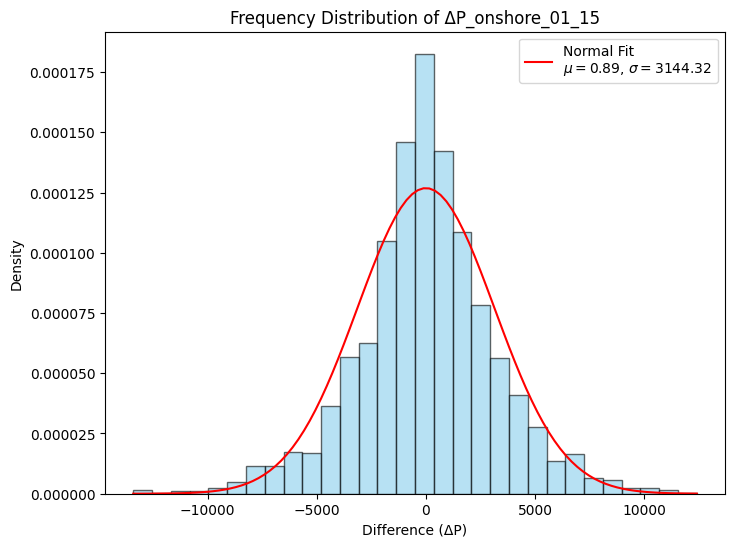

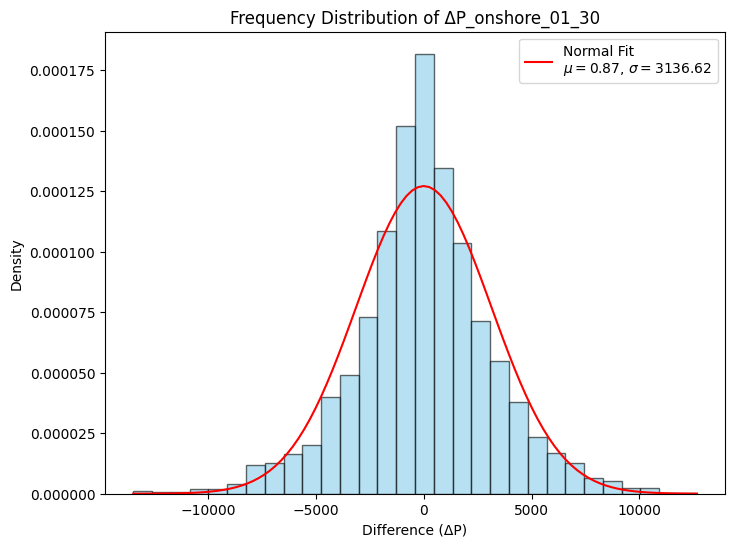

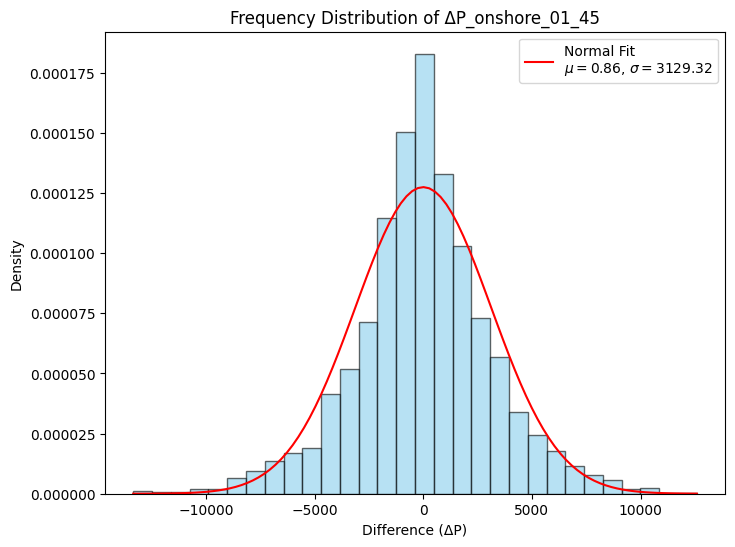

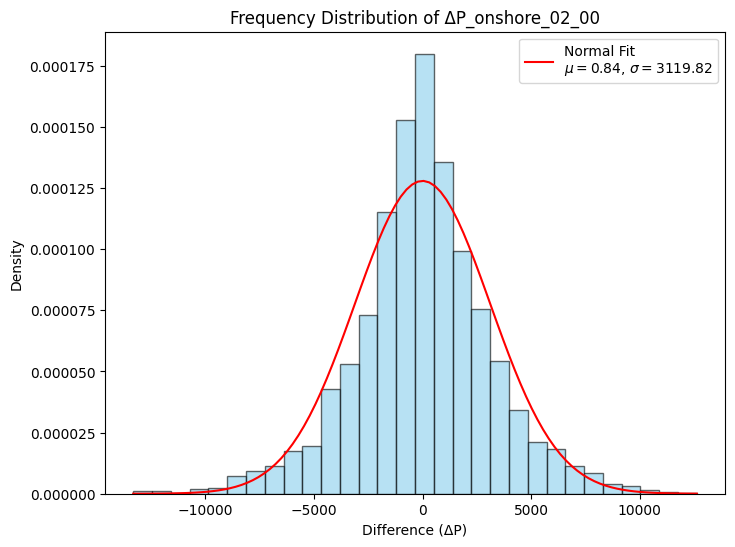

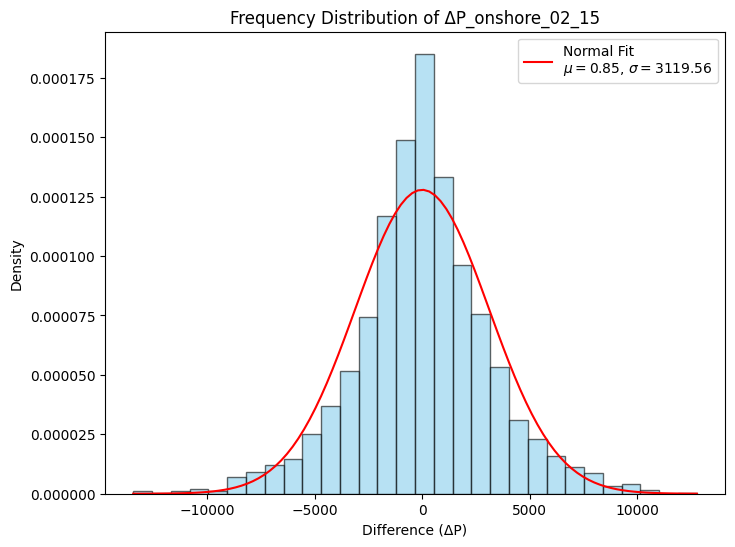

In [4]:
plot_difference_histograms(reshaped)

Analyse the daily time series for each 15-minute interval separately by fitting a Weibull distribution to the time series data for each 15-minute. To be more flexible fit a Weibull distribution rather than a Gaussian distribution. The most important parameter is the "shape" parameter. For "shape" <= 1 the maximum of the distribution is at zero; for "shape" > 1 the maximum is above zero. The scale parameter simply says how large the variable can be

Why weibull? its a flexible distribution because the shape parameter allows for distributions that peak at zero and distributions that ressemble the normal distribution

In [5]:
def get_weibull_mle(data):
    data = data[np.isfinite(data)]
    shape_param, loc, scale_param = weibull_min.fit(data, floc=0)  # floc=0 fixes the location parameter
    return shape_param, scale_param

def get_weibull_mles(data):
    mles = []
    for column in data.columns:
        shape, scale = get_weibull_mle(data[column])
        th_mean = scale*gamma(1+1/shape)
        mean = data[column].mean()
        error = (th_mean - mean) / mean
        mles.append({"time_interval": column, "shape": shape, "scale": scale, "th_mean": th_mean, "mean": mean, "error": error})
    return pd.DataFrame(mles)

Inspect the result of the fit for each 15 minute interval (onshore)
The mean of the data is pretty close to the theoretical mean

In [6]:
mles = get_weibull_mles(reshaped)
weibull_parameters_onshore = mles[mles['time_interval'].str.startswith('onshore')]
weibull_parameters_onshore

,time_interval,shape,scale,th_mean,mean,error
96,onshore_00_00,1.234070,4234.751879,3955.959383,3951.308388,0.001177
97,onshore_00_15,1.229869,4216.769248,3942.362660,3937.562208,0.001219
98,onshore_00_30,1.223095,4197.718625,3929.791219,3925.318990,0.001139
99,onshore_00_45,1.216945,4177.616407,3915.812628,3911.964765,0.000984
100,onshore_01_00,1.211925,4157.172339,3900.658748,3897.234799,0.000879
...,...,...,...,...,...,...
187,onshore_22_45,1.252746,4328.702775,4029.673580,4024.471304,0.001293
188,onshore_23_00,1.249402,4310.649440,4015.307062,4010.149095,0.001286
189,onshore_23_15,1.245312,4292.834732,4001.722830,3996.628197,0.001275
190,onshore_23_30,1.241225,4274.951816,3988.090456,3983.315346,0.001199


Plotting the distribution of the "shape" parameter for the 96 time intervals (onshore). We see that most often positive power is produced.

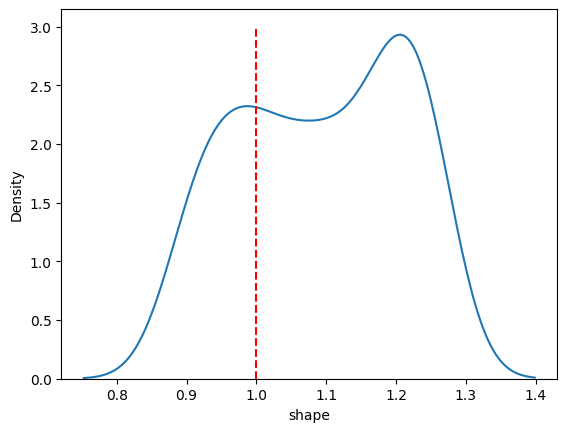

In [7]:
sns.kdeplot(weibull_parameters_onshore["shape"])
plt.vlines(x=1, ymin=0, ymax=3, color='r', linestyle='--')

Plotting the values for the other parameter (scale) which is only relevant for normalization

<Axes: xlabel='scale', ylabel='Density'>

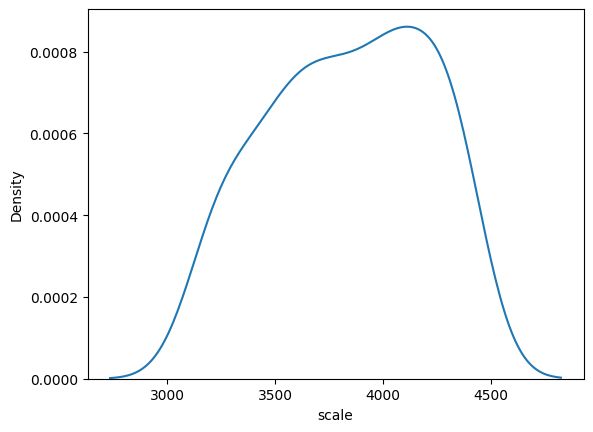

In [8]:
sns.kdeplot(weibull_parameters_onshore["scale"])

In [9]:
weibull_parameters_onshore[weibull_parameters_onshore['shape'] <= 0.9]

,time_interval,shape,scale,th_mean,mean,error
126,onshore_07_30,0.897159,3193.459460,3365.941562,3362.995011,0.000876
127,onshore_07_45,0.894309,3177.622580,3355.146064,3352.166511,0.000889
128,onshore_08_00,0.896678,3181.552412,3354.382344,3351.692236,0.000803


Plot the frequency distribution of the data and the weibull for a selected 15 minute time interval.

In [10]:
def plot_weibull_for_one_interval(Dataframe, time_interval):


    # Step 1: Get the data from the DataFrame

    ## interessanter Wert 07_30
    #data = minute_to_daily_50Hertz(reshaped)['onshore_21_30']
    data = Dataframe[f'onshore_{time_interval}']

    # Step 2: Clean the data by removing NaN and infinite values
    data_clean = data[np.isfinite(data)]

    # Step 3: Plot the histogram of the cleaned data
    plt.figure(figsize=(10, 6))
    plt.hist(data_clean, bins=30, density=True, alpha=0.6, color='blue', label='Data Histogram')

    # Step 4: Fit the Weibull distribution to the cleaned data
    shape_param, loc, scale_param = weibull_min.fit(data_clean, floc=0)  # floc=0 fixes the location parameter

    # Step 5: Generate x values for the Weibull PDF within the specified range
    x = np.linspace(0, 16000, 100)  # Specify range from 0 to 16000

    # Step 6: Calculate the Weibull PDF
    weibull_pdf = weibull_min.pdf(x, shape_param, loc=loc, scale=scale_param)

    # Step 7: Plot the Weibull distribution
    plt.plot(x, weibull_pdf, 'r-', lw=2, label='Weibull Fit (shape={:.2f}, scale={:.2f})'.format(shape_param, scale_param))

    # Finalize the plot
    plt.title(f'Histogram and Weibull Distribution Fit for time interval {time_interval}')
    plt.xlabel('Power (kW)')
    plt.ylabel('Density')
    plt.xlim(0, 16000)  # Set x-axis limits from 0 to 16000
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
t1 = '21_30'
t2 = '08_00'
t3 = '18_00'

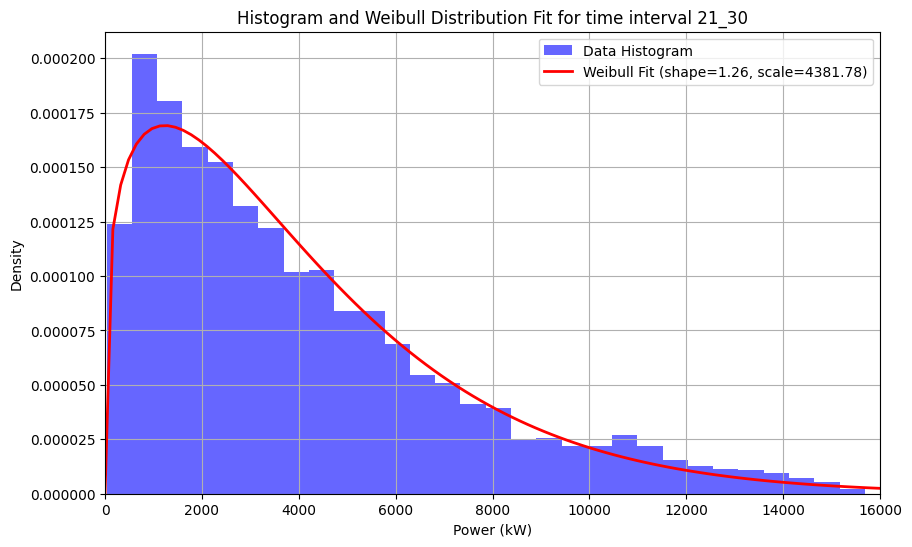

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:2581: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


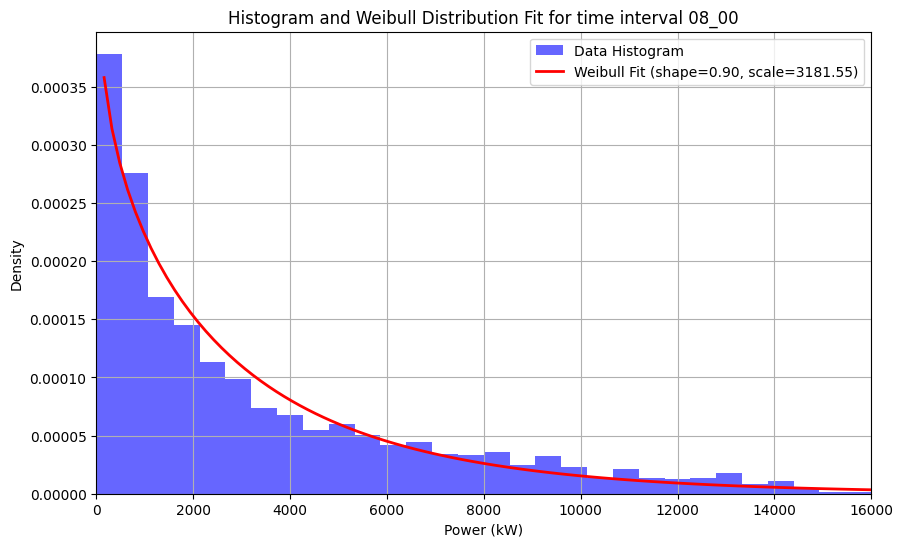

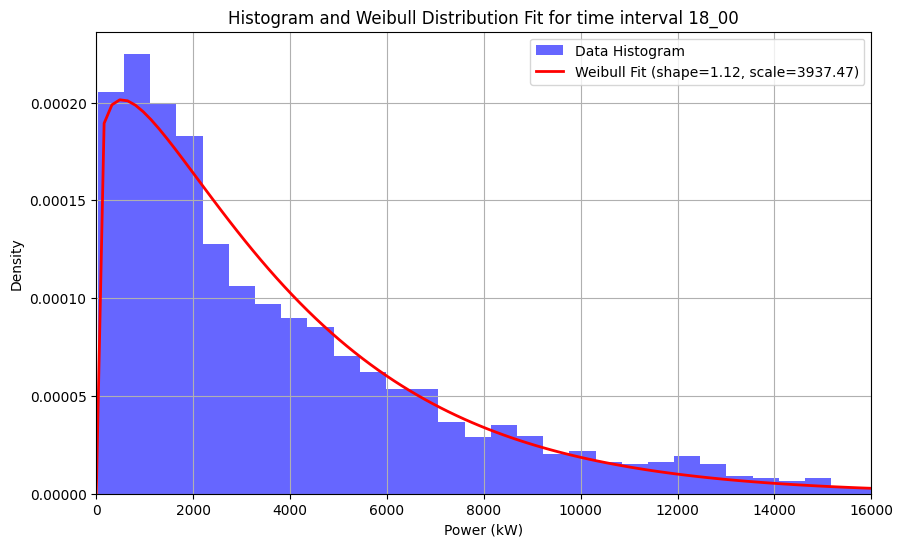

In [12]:
plot_weibull_for_one_interval(reshaped, t1)
plot_weibull_for_one_interval(reshaped, t2)
plot_weibull_for_one_interval(reshaped, t3)

Interpretation:
- At 08:00 the most likely power is very small (Weibull would predict zero)
- At 18:00, 21:00 the most likely power is around 700-1000 kW

Implication for forecasting model:
- Has to take into account that different time intervals result in different distribution shapes


## Time Series of mean per month

## Time Series of 1 month

In [13]:
# Filter the data for January 2024 (or any month you want)
filtered_data = df.loc['2024-01']  # This will return all data for January 2024

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data.index, filtered_data['onshore'], color='b', label='Onshore')
plt.title('Time Series of Onshore Data for January 2024')
plt.xlabel('Date')
plt.ylabel('Onshore')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

In [ ]:
def minute_to_daily_50Hertz(df):
    df = df.copy()
    original_shape = df.shape
    original_frequency = int((df.index[1] - df.index[0]).seconds / 60)

    if isinstance(df, pd.Series):
        df = df.to_frame()

    columns = df.columns
    df.index.name = ""
    df.index = pd.to_datetime(df.index)

    # Extract the date and formatted time
    df["date"] = df.index.date ##creates a new column date, containing just the date (without the time) from the index
    df["time"] = df.index.strftime("%H_%M") ##addsa new column time to represent the time of day in HH_MM format

    # Perform the pivot (reshape)
    reshaped_df = df.pivot(index="date", columns="time", values=columns) #reshapes the DataFrame: each unique date --> row index, each unique time --> a column, values in each cell are the original data values

    # Flatten multi-level columns if necessary
    reshaped_df.columns = [f"{col[0]}_{col[1]}" for col in reshaped_df.columns]
    if reshaped_df.index.dtype == "object":
        reshaped_df.index = pd.to_datetime(reshaped_df.index)

    return reshaped_df

### Focuses on onshore

In [ ]:
data = minute_to_daily(df)
mles = get_weibull_mles(data)
onshore = mles[mles['time_interval'].str.startswith('onshore')]
onshore

## Plotting the distribution of the "shape" parameter for the 96 time intervals (onshore). We see that most often positive power is produced. 

### Find values with shape < 1

### First attempt to include installed capacity. Since data is updated yearly only, I need to interpolate. This is an approximation since in reality more capacity is not added continuously 

In [ ]:
def load_installed_capacity(start_date="2017-01-01", end_date="2024-01-01", method="linear"):

    data = {
        'date': ['2017-06-01', '2018-06-01', '2019-06-01', '2020-06-01', '2021-06-01', '2022-06-01', '2023-06-01'],
        'installed_capacity': [17866, 18346, 18711, 19138, 19748, 20414, 21078]
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Convert 'year' column to datetime format
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Set 'year' as the index
    df.set_index('date', inplace=True)

    # Resample to 15-minute intervals and interpolate using the specified method
    df = df.resample("15min").interpolate(method=method)

    dt = pd.date_range(start_date, end_date, inclusive="left", freq="15min")
    df = df.reindex(dt).bfill().ffill()

    return df

In [ ]:
load_installed_capacity("2016-01-01")

In [ ]:
load_installed_capacity("2016-01-01").plot()

In [ ]:
df["installed_capacity"] = load_installed_capacity()

### The red line shows the maximum power output achieved and green the installed capacity. The increase is more or less parallel, showing that it makes sense to consider a normalized power output.

In [ ]:
df.onshore.plot()
df.onshore.expanding().max().plot(color="red")
df.installed_capacity.plot(color="green")

In [ ]:
[(x, df.resample('M').mean().onshore.autocorr(lag=x).item()) for x in range(1,13)]

In [ ]:
pd.plotting.autocorrelation_plot(df.resample('M').mean().offshore)

In [ ]:
# Plot the data
#df.plot(title="Time Series Data")
df2 = df.resample('D').mean()
column = "onshore"
# 1. Autocorrelation and Partial Autocorrelation to detect periodicity
lag_acf = acf(df2[column], nlags=40)
lag_pacf = pacf(df2[column], nlags=40)
display(lag_acf)
display(lag_pacf)

In [ ]:
# 2. Fit an ARMA model to the data (ARMA(p,q) model)
model = ARIMA(df[column], order=(2, 0, 2))  # ARMA is a special case of ARIMA(p, 0, q)
arma_model = model.fit()

# Print the summary of the fitted model
print(arma_model.summary())

# 3. Analyze the residuals to check for periodicity in the residuals
residuals = arma_model.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARMA Model')
plt.show()

In [ ]:
# 4. Optionally, use FFT to find periodicity
fft_vals = np.fft.fft(df[column])
fft_freq = np.fft.fftfreq(len(fft_vals))

plt.figure(figsize=(10, 4))
plt.plot(fft_freq, np.abs(fft_vals))
plt.title('Frequency Spectrum')
plt.show()

In [ ]:
lag_acf

In [ ]:
lag_pacf

In [ ]:
df.onshore.hist(bins=30)

In [ ]:
df.offshore.hist(bins=30)

In [ ]:
sns.kdeplot(df.onshore)

In [ ]:
sns.kdeplot(df.offshore)

In [ ]:
df.Area.unique()